- Labels in this dataset:
    - 0: motobike


- More info:
    - Number of classes: 1
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [3]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee6579e3-8de3-e416-1070-1958ff19d1f1)
GPU 1: Tesla T4 (UUID: GPU-62843bde-e8d9-eb40-6643-85a369a1ad26)


# Installs/Imports

In [4]:
! pip install --upgrade ultralytics -qq


In [5]:
import ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.40


In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [7]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [8]:
class CFG:
    SEED = 1
    # classes
    NUM_CLASSES = 1
    CLASSES = ['motobike']

    # training
    EPOCHS = 50 
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov10n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/motobike-dectection1/motobike_Detection'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [9]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [10]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- motobike
nc: 1
test: /kaggle/input/motobike-dectection1/motobike_Detection/test
train: /kaggle/input/motobike-dectection1/motobike_Detection/train
val: /kaggle/input/motobike-dectection1/motobike_Detection/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1080, 1920, 3) 



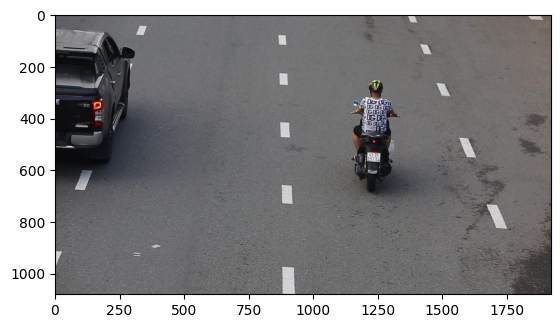

In [11]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
example_image_path = '/kaggle/input/motobike-dectection1/motobike_Detection/train/images/3J4A7817_frame_0003_png.rf.3403487b97b4a315795f7b3c5762ce25.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

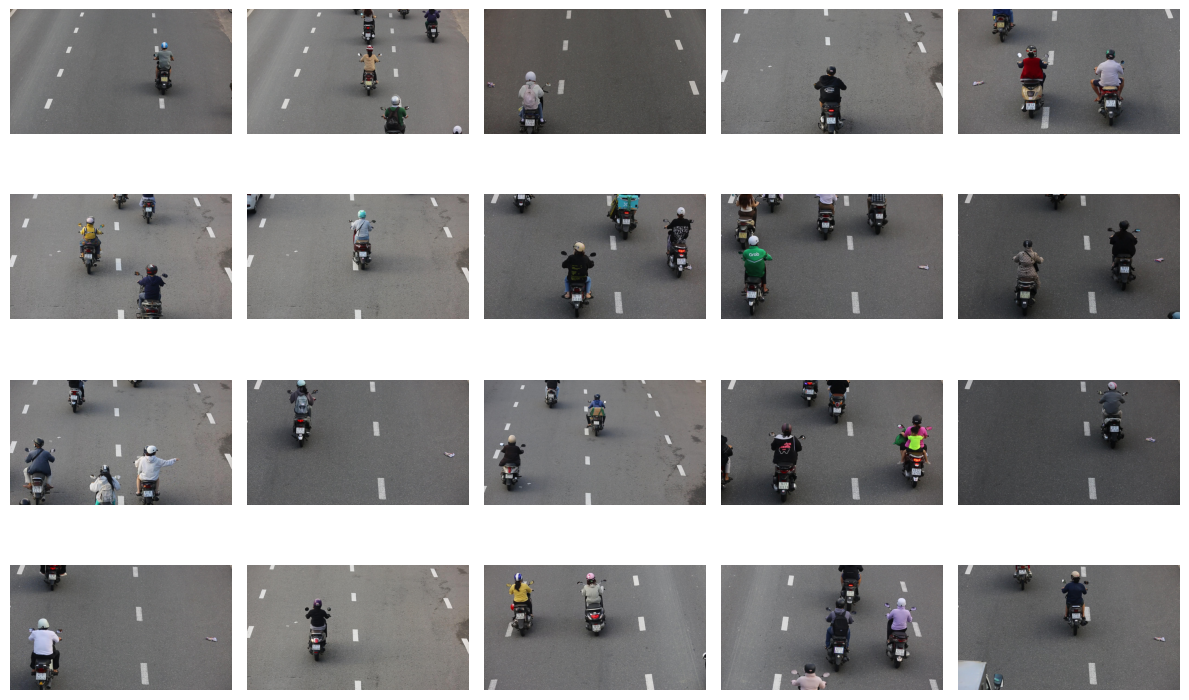

In [12]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
# folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
folder_path = '/kaggle/input/motobike-dectection1/motobike_Detection/train/images'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [14]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1920, 'height': 1080, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df


CPU times: user 111 ms, sys: 157 ms, total: 268 ms
Wall time: 4.88 s


Mode  motobike  Data_Volume
0  train      1195         1195
1  valid       398          398
2   test       398          399

# Train


In [16]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 5.59M/5.59M [00:00<00:00, 77.5MB/s]


In [ ]:
!pip install -U ipywidgets

In [19]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)

In [20]:
### train
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (640,640),
    seed = CFG.SEED,
    device = '0,1', #[0,1], # 0
    workers=4,
    name='yolov10n_MotobikeDetection'),

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov10n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0,1, workers=4, project=None, name=yolov10n_MotobikeDetection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/train/labels... 1195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1195/1195 [00:01<00:00, 845.63it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/valid/labels... 398 images, 0 backgrounds, 0 corrupt: 100%|██████████| 398/398 [00:00<00:00, 584.25it/s]/s]
train: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/train/labels... 580 images, 0 backgrounds, 0 corrupt:  49%|████▊     | 580/1195 [00:00<00:00, 683.95it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/train/labels... 1195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1195/1195 [00:01<00:00, 617.75it/s]


Plotting labels to runs/detect/yolov10n_MotobikeDetection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov10n_MotobikeDetection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.02G      1.881       6.23      2.056         10        640: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


                   all        398        593    0.00497          1      0.629      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         3G      1.627      3.918      1.905         20        640: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


                   all        398        593      0.981      0.515      0.905       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         3G      1.556      3.334      1.904         14        640: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


                   all        398        593      0.868      0.532      0.748      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         3G      1.645      2.902      1.922         14        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.49it/s]


                   all        398        593      0.917      0.914      0.962      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.98G      1.583      2.401      1.887         22        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        398        593      0.889      0.943      0.959      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         3G      1.527      2.086        1.9         21        640: 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        398        593      0.914      0.933      0.973      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         3G      1.555      1.892      1.911         29        640: 100%|██████████| 38/38 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


                   all        398        593      0.917      0.929      0.972      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         3G       1.51      1.702      1.889         12        640: 100%|██████████| 38/38 [00:14<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


                   all        398        593       0.91      0.916      0.964      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         3G      1.493      1.542      1.902         13        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        398        593      0.951      0.916      0.983      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         3G      1.532      1.454      1.929         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


                   all        398        593      0.939      0.946      0.976      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         3G      1.507       1.39      1.911         22        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


                   all        398        593      0.908      0.907      0.974      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.98G       1.44      1.196      1.872         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


                   all        398        593      0.959       0.95      0.985      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.02G      1.453       1.17      1.896         14        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


                   all        398        593      0.937      0.961      0.979      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         3G      1.421      1.112      1.876         15        640: 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        398        593      0.921      0.938      0.971       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         3G      1.428      1.103      1.904         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


                   all        398        593      0.952      0.948      0.985      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.98G      1.434      1.029      1.873         18        640: 100%|██████████| 38/38 [00:15<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


                   all        398        593      0.946      0.949      0.983      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.99G      1.437      1.023      1.888         24        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


                   all        398        593      0.929      0.948       0.98       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.99G      1.376     0.9723      1.863         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.56it/s]


                   all        398        593       0.93      0.922      0.978      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.98G      1.423     0.9471      1.899         19        640: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


                   all        398        593      0.938      0.971      0.982      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.98G      1.347     0.8956      1.863          9        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.44it/s]


                   all        398        593      0.954      0.973      0.986      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         3G      1.423     0.9059      1.893         14        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


                   all        398        593      0.931       0.98      0.985      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.99G      1.365      0.855      1.871         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


                   all        398        593      0.943      0.975      0.986      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.99G      1.322     0.8005      1.851         20        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        398        593      0.964      0.961       0.99      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         3G      1.347     0.8281      1.867         23        640: 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


                   all        398        593      0.937       0.98      0.983      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.99G      1.362     0.8228      1.883         23        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]


                   all        398        593      0.934      0.949      0.981      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.99G      1.341     0.7973      1.864         26        640: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.58it/s]


                   all        398        593      0.956      0.964      0.984       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.99G      1.341     0.8021      1.882         18        640: 100%|██████████| 38/38 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


                   all        398        593      0.963      0.964      0.988      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.99G      1.338     0.7687      1.864         24        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]


                   all        398        593      0.953       0.96      0.986      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.98G      1.331     0.7683      1.849         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


                   all        398        593      0.963      0.958      0.988      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.99G      1.307     0.7697      1.875         15        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


                   all        398        593      0.957       0.97      0.989      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.99G      1.296     0.7519      1.872         17        640: 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


                   all        398        593      0.962       0.97      0.989      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.99G      1.292     0.7401      1.856         17        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]


                   all        398        593      0.976      0.958      0.989      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.99G      1.285     0.6929      1.832         13        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


                   all        398        593      0.955      0.971      0.985      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.98G      1.277      0.742      1.842         12        640: 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        398        593      0.966      0.958      0.988      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         3G      1.274     0.6997      1.841         16        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


                   all        398        593      0.958      0.966      0.987      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.99G      1.277      0.707      1.838         15        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


                   all        398        593      0.968      0.961      0.988      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.99G      1.247      0.667      1.841         26        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


                   all        398        593      0.965      0.965      0.989       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         3G      1.239     0.6771      1.839         13        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


                   all        398        593      0.965      0.971      0.987      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.98G      1.235     0.6535      1.837         14        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.42it/s]


                   all        398        593      0.959      0.985      0.991      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         3G      1.151     0.6207      1.785         21        640: 100%|██████████| 38/38 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


                   all        398        593      0.979      0.961       0.99      0.841
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.98G      1.151     0.6349      1.755         11        640: 100%|██████████| 38/38 [00:16<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


                   all        398        593       0.97      0.969      0.988       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.98G       1.14     0.5864      1.744         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


                   all        398        593      0.962      0.965      0.988      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.98G       1.12     0.5637      1.751          8        640: 100%|██████████| 38/38 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


                   all        398        593      0.967      0.974      0.991      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.98G      1.102     0.5646      1.729          7        640: 100%|██████████| 38/38 [00:14<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.34it/s]


                   all        398        593      0.979      0.965      0.987      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.98G      1.101     0.5613       1.72         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


                   all        398        593       0.99      0.966      0.991      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.98G      1.128     0.5633      1.742          8        640: 100%|██████████| 38/38 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        398        593      0.967      0.978       0.99      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.98G      1.093     0.5505      1.732         11        640: 100%|██████████| 38/38 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


                   all        398        593      0.964      0.981       0.99      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.98G      1.084     0.5416      1.719          7        640: 100%|██████████| 38/38 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


                   all        398        593      0.984      0.963      0.991       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.98G      1.081     0.5241      1.724          9        640: 100%|██████████| 38/38 [00:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


                   all        398        593      0.976      0.976      0.991      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.98G      1.079     0.5228      1.735          8        640: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


                   all        398        593      0.974      0.965       0.99      0.839

50 epochs completed in 0.266 hours.
Optimizer stripped from runs/detect/yolov10n_MotobikeDetection/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/yolov10n_MotobikeDetection/weights/best.pt, 5.7MB

Validating runs/detect/yolov10n_MotobikeDetection/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


                   all        398        593       0.98      0.961       0.99      0.841
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/yolov10n_MotobikeDetection


# Export

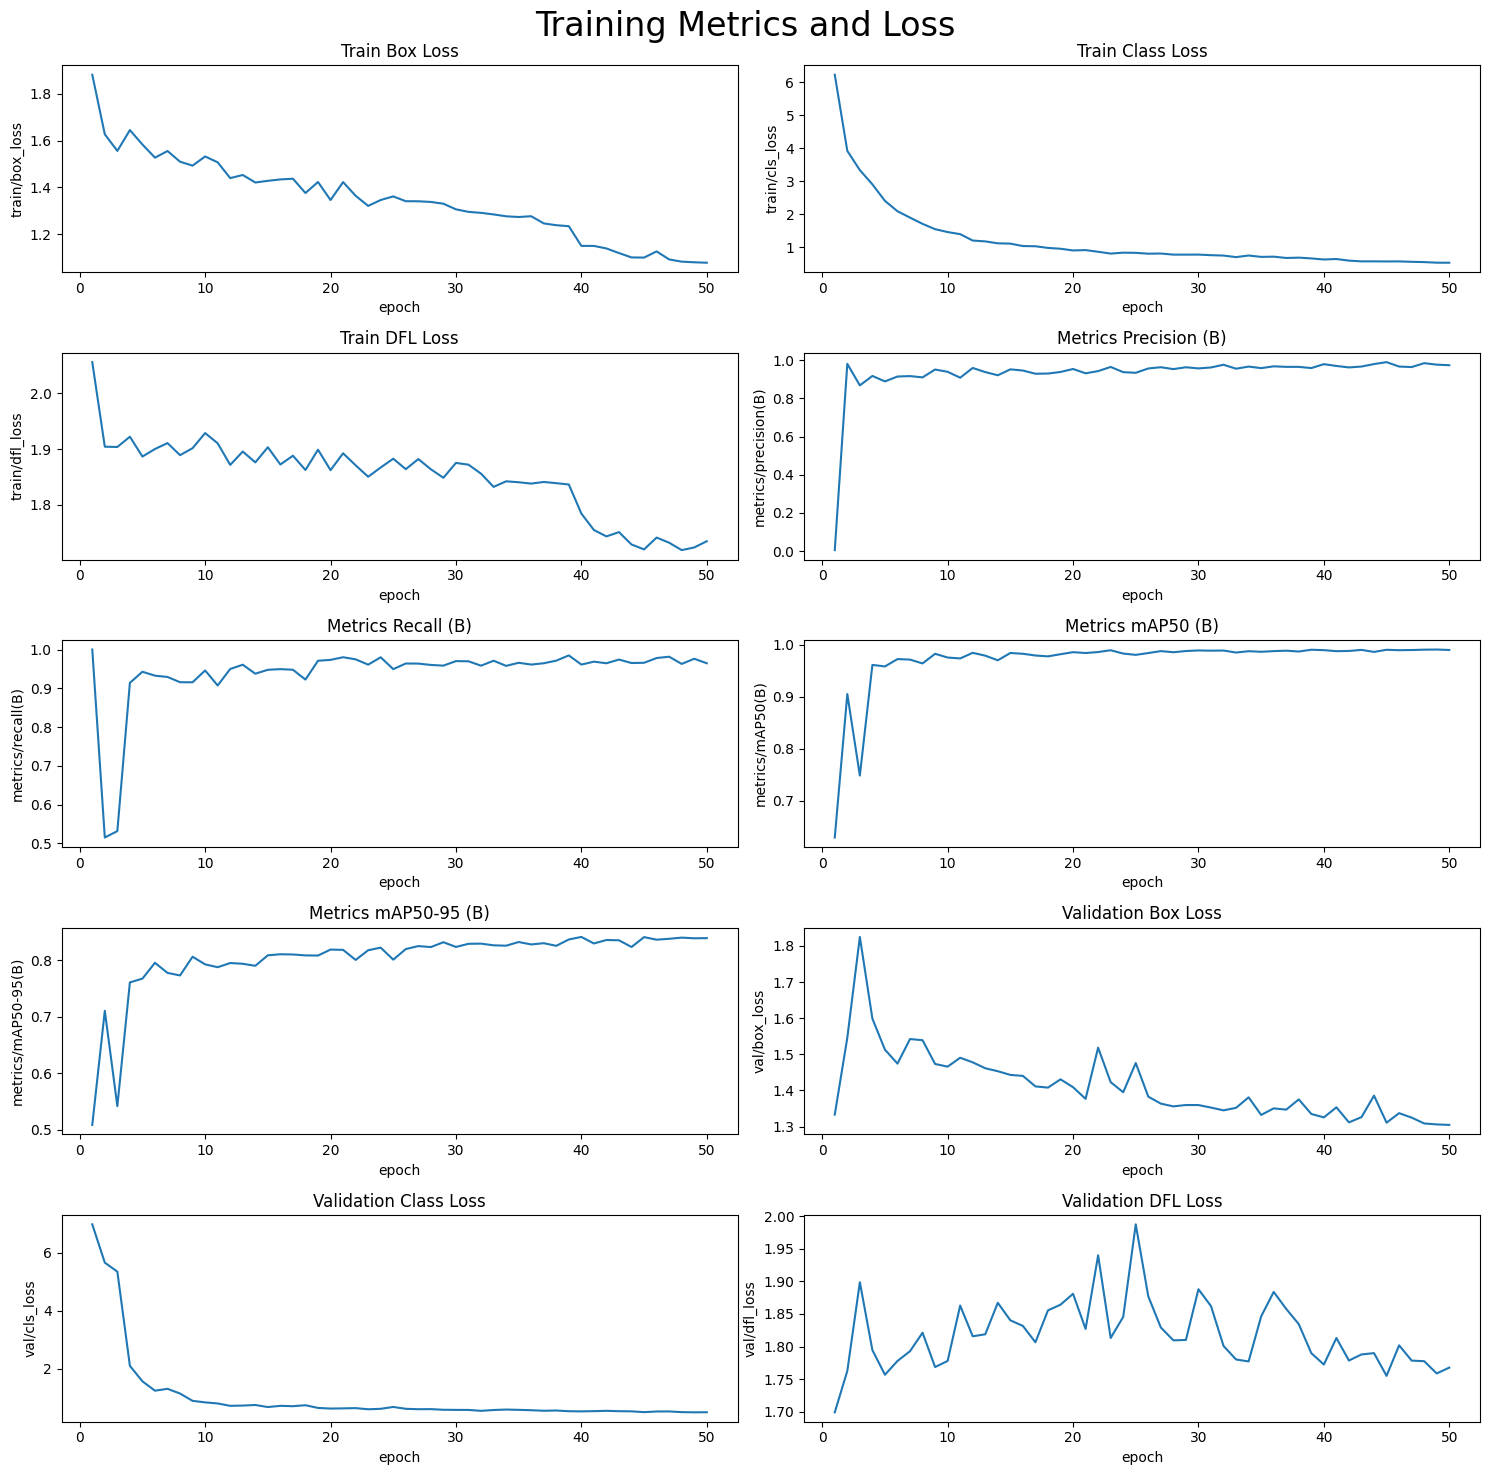

In [21]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov10n_MotobikeDetection/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [22]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov10n_MotobikeDetection/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/input/motobike-dectection1/motobike_Detection/test/labels... 399 images, 1 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:01<00:00, 259.07it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/motobike-dectection1/motobike_Detection/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


                   all        399        600      0.984      0.975      0.988      0.846
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val


In [23]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.8457872215813653
Mean Average Precision @ .50   : 0.9879169534664837
Mean Average Precision @ .70   : 0.9839076719234457


# Test model



image 1/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0005_png.rf.88b5e777d974d4e696a4e4a83cfc6492.jpg: 384x640 1 motobike, 43.1ms
image 2/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0012_png.rf.34794bc0be162fce338596a5b39e4ffb.jpg: 384x640 1 motobike, 12.2ms
image 3/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0014_png.rf.16ad36c5dc3d69d624a18191cc7cc499.jpg: 384x640 2 motobikes, 9.7ms
image 4/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0014_png.rf.648caf0d8125be251560d0c88bc9bb1d.jpg: 384x640 2 motobikes, 10.6ms
image 5/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0037_png.rf.8760a4ad236c6a0724d25712b0baabdf.jpg: 384x640 1 motobike, 9.7ms
image 6/399 /kaggle/input/motobike-dectection1/motobike_Detection/test/images/3J4A7817_frame_0038_png.rf.b47385379294a55ee7114263f76d530b.jpg: 384x64

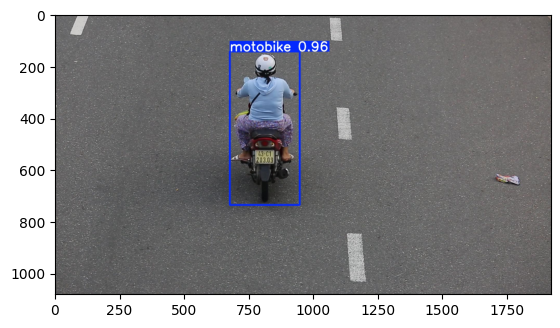

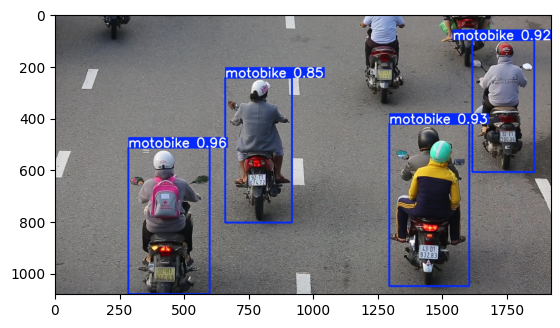

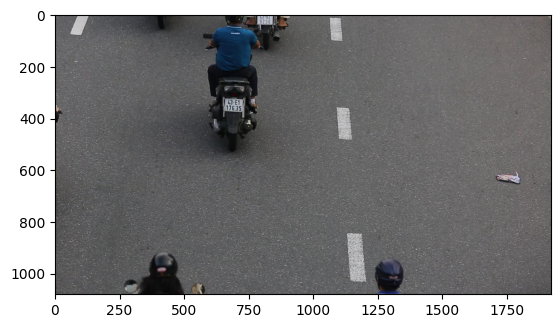

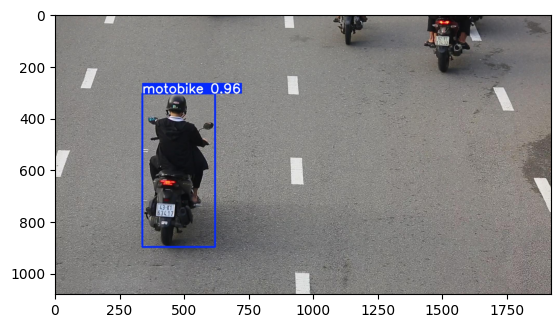

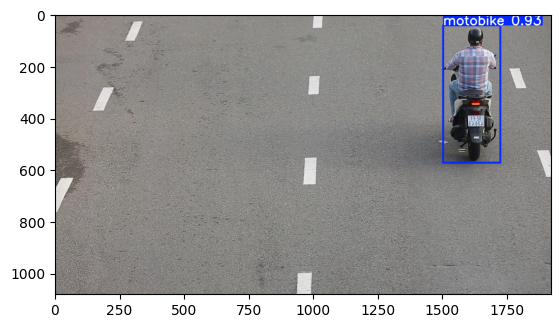

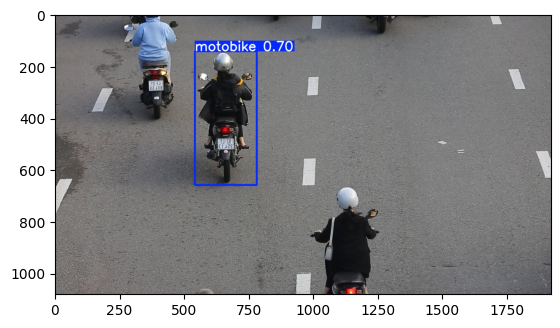

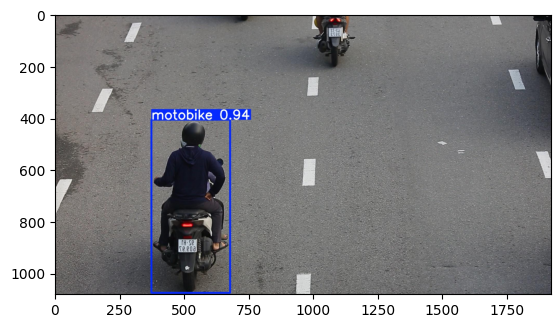

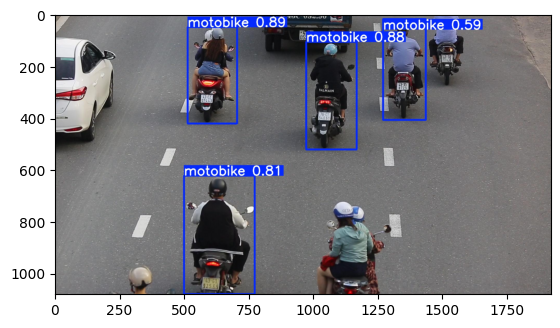

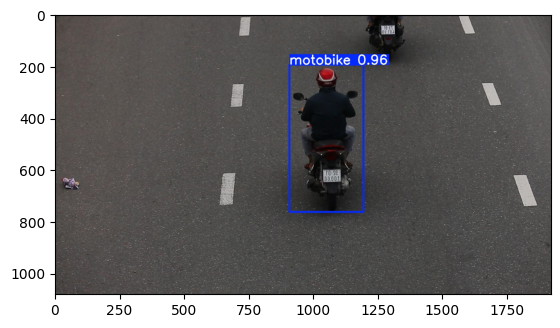

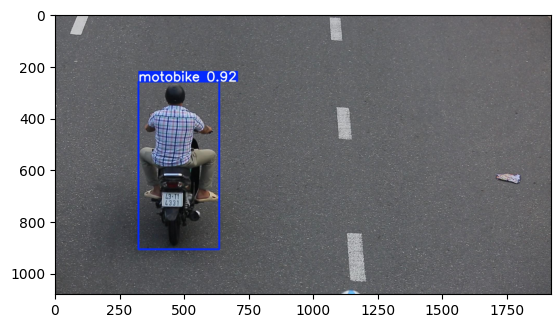

In [24]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [25]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/predict/ (stored 0%)
  adding: kaggle/working/runs/detect/predict/3J4A7819_frame_0204_png.rf.a8d1049e9a3f9799c5d9722474d46051.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/7828_frame_0011_png.rf.8611ad9bff8141ae96df8d1b1486df6f.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/3J4A7818_frame_0307_png.rf.6c224fd6824448e0844e790143195ffc.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/predict/7825_frame_0119_png.rf.1c201e1fb97ae9cd4b811898f4768597.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/7832_frame_0027_png.rf.88aadeb8cc00fa9d3a3db260266c861f.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/3J4A7831_frame_0086_png.rf.3710eee5aa884c033828d20b20f7e999.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/3J4A7821_frame_0025_png.rf.ebc4dbab56259

In [18]:
 !rm -rf /kaggle/working/runs